In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

### YOLO pretraining on RSNA Dataset

In [2]:
loss_path = "./losses_giou_pretrained_40/"
train_loss = np.load(loss_path + "yolov5_train_loss_39.np.npy")
val_loss = np.load(loss_path + "yolov5_val_loss_39.np.npy" )
assert len(val_loss) == len(train_loss)

In [14]:
train_single_losses = np.load(loss_path + "yolov5_train_loss_single_41.np.npy")
val_single_losses = np.load(loss_path + "yolov5_val_loss_single_41.np.npy")

In [3]:
file = open(loss_path + "yolov5_general_test_results_39.pickle",'rb')
metrics_list = pickle.load(file)
file.close()

type(metrics_list)

list

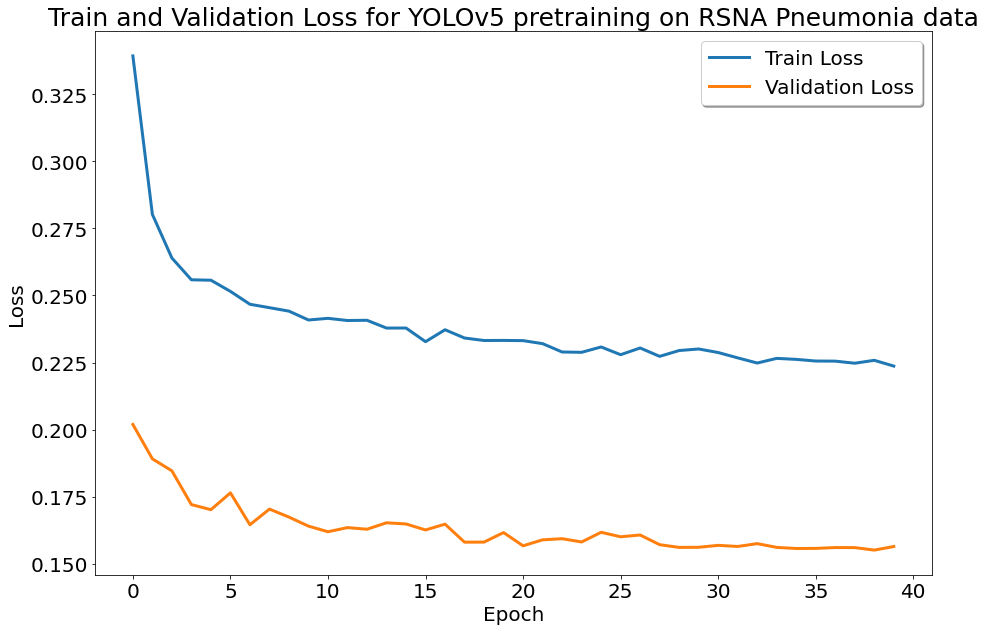

In [4]:
x = [i for i in range(len(val_loss))]

fig = plt.figure(figsize=(15,10))
plt.plot(x,train_loss , label="Train Loss", linewidth=3)
plt.plot(x,val_loss, label="Validation Loss", linewidth=3)
plt.title("Train and Validation Loss for YOLOv5 pretraining on RSNA Pneumonia data", fontsize=25)
plt.ylabel("Loss",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(shadow=True, prop={'size': 20})
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )
plt.show(block=True)
fig.savefig("kp.jpg",dpi=200)

In [5]:
precision, recall, ap, f1, ap_class, ap50, mp, mr, map50 = [], [], [], [], [], [], [], [], []

In [6]:
for metrics in metrics_list:
    precision.append(metrics["precision"][0])
    recall.append(metrics["recall"][0])
    ap.append(metrics["ap"][0])
    f1.append(metrics["f1"][0])
    ap_class.append(metrics["ap_class"][0])
    ap50.append(metrics["ap50"][0])
    mp.append(metrics["mp"])
    mr.append(metrics["mr"])
    map50.append(metrics["map50"])

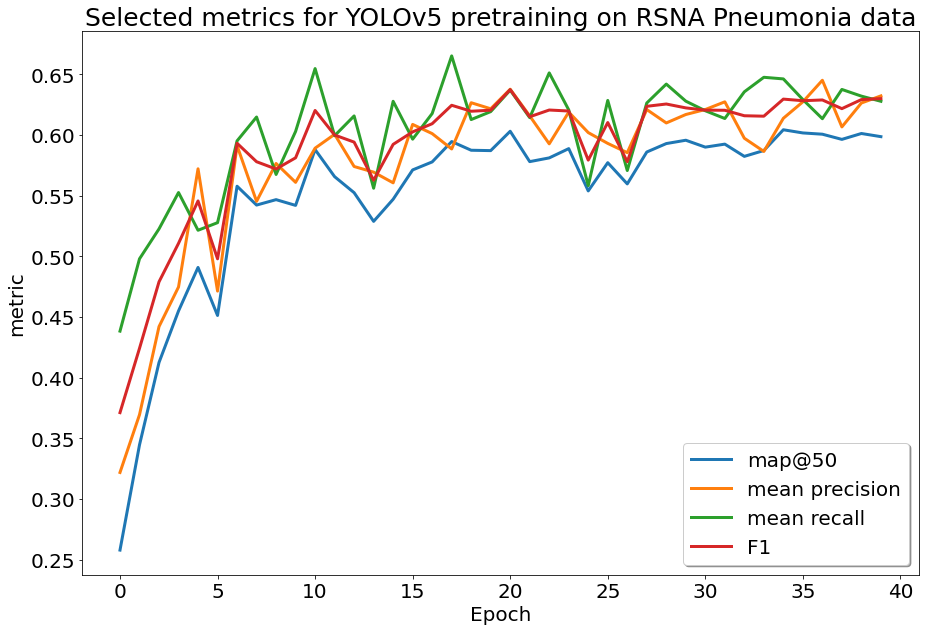

In [7]:
x = [i for i in range(len(map50))]

fig = plt.figure(figsize=(15,10))
plt.plot(x,map50 , label="map@50", linewidth=3)
plt.plot(x,mp, label="mean precision", linewidth=3)
plt.plot(x,mr, label="mean recall", linewidth=3)
plt.plot(x,f1, label="F1", linewidth=3)
plt.title("Selected metrics for YOLOv5 pretraining on RSNA Pneumonia data", fontsize=25)
plt.ylabel("metric",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(shadow=True, prop={'size': 20})
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )
plt.show(block=True)
path = "../../imgs/models/metrics_giou_pretrained_yolo_40.png"
fig.savefig("kp2",dpi=200)

### YOLO training on SIIM

In [ ]:
loss_path = "./losses_final_giou/"
train_loss = np.load(loss_path + "yolov5_train_loss_39.np.npy")
val_loss = np.load(loss_path + "yolov5_val_loss_39.np.npy" )
assert len(val_loss) == len(train_loss)

In [ ]:
file = open(loss_path + "yolov5_general_test_results_39.pickle",'rb')
metrics_list = pickle.load(file)
file.close()

type(metrics_list)

In [ ]:
x = [i for i in range(len(val_loss))]

fig = plt.figure(figsize=(15,10))
plt.plot(x,train_loss , label="Train Loss", linewidth=3)
plt.plot(x,val_loss, label="Validation Loss", linewidth=3)
plt.title("Train and Validation Loss for YOLOv5 on SIIM-COVID19 data", fontsize=25)
plt.ylabel("Loss",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(shadow=True, prop={'size': 20})
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )
plt.show(block=True)
fig.savefig("../../imgs/models/loss_yolo_giou_40_siim.png",dpi=200)

In [ ]:
precision, recall, ap, f1, ap_class, ap50, mp, mr, map50 = [], [], [], [], [], [], [], [], []
for metrics in metrics_list:
    precision.append(metrics["precision"][0])
    recall.append(metrics["recall"][0])
    ap.append(metrics["ap"][0])
    f1.append(metrics["f1"][0])
    ap_class.append(metrics["ap_class"][0])
    ap50.append(metrics["ap50"][0])
    mp.append(metrics["mp"])
    mr.append(metrics["mr"])
    map50.append(metrics["map50"])

In [ ]:
x = [i for i in range(len(map50))]

fig = plt.figure(figsize=(15,10))
plt.plot(x,map50 , label="map@50", linewidth=3)
plt.plot(x,mp, label="mean precision", linewidth=3)
plt.plot(x,mr, label="mean recall", linewidth=3)
plt.plot(x,f1, label="F1", linewidth=3)
plt.title("Selected metrics for YOLOv5 on SIIM-COVID19 data", fontsize=25)
plt.ylabel("metric",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(shadow=True, prop={'size': 20})
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )
plt.show(block=True)
fig.savefig("../../imgs/models/metrics_yolo_30_siim.png",dpi=200)

## Inference

In [129]:
import torch
from models.yolo import Model
from utils.datasets import LoadImages, LoadImagesAndLabels
from utils.general import check_img_size, non_max_suppression, scale_coords, xywhn2xyxy
import matplotlib.patches as patches
from dataset import ChestCocoDetection
from torchvision import transforms
import tkinter as tk
import cv2

In [158]:
IMAGE_SIZE = 512
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.2

In [131]:
model = Model(cfg="yolo5l.yaml",ch=3,nc=1)
trained_weights = torch.load("./models_final_giou_10/yolov5_epoch_14.pt")
model.load_state_dict(trained_weights, strict=False)  # load
model.eval()

stride = int(model.stride.max())  # model stride
img_size = check_img_size(IMAGE_SIZE, s=stride)  # check img_size
print(img_size)

512


In [132]:
# see sample predcition on one image in validation
test_image_path = "../../data/siim-covid19-detection/images/train/292c0aeda46d.png"
test_label_path = "../../data/siim-covid19-detection/labels/train/292c0aeda46d.txt"

In [133]:
samples = LoadImages(test_image_path, img_size, stride)
idx = np.random.randint(len(test))
test_img = test.__getitem__(idx)

In [162]:
def add_bounding_boxes(target, ax):
    boxes = target
    for box in boxes:
        mp_box = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor="r", facecolor='none')
        ax.add_patch(mp_box)

def show_samples_for(test, train):
    fig, axs = plt.subplots(1, 2, figsize=(10,8))
    for im_i, (img, data) in enumerate([test, train]):
        ax = axs[im_i] if isinstance(axs, np.ndarray) else axs
        ax.set_title(f'Instance / Image Nr. {im_i + 1} / {2}')
        plt.figure()
        ax.imshow(img.permute(1,2,0), cmap=plt.cm.bone)
        add_bounding_boxes(data, ax)
    plt.show()

In [135]:
def refine_det(boxes, labels, scores):
    boxes = boxes.clip(0,1)

    boxes_out = []
    labels_out = []
    scores_out = []
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        if x1==x2 or y1==y2:
            continue
        box = [min(x1,x2), min(y1,y2), max(x1,x2), max(y1,y2)]
        boxes_out.append(box)
        labels_out.append(label)
        scores_out.append(score)
    return boxes_out, labels_out, scores_out

In [138]:
gt = torch.tensor([[0.24809027777777778, 0.422244094488189 ,0.184375, 0.3059055118110236], [
    0.7088541666666667 ,0.5190944881889764, 0.1482638888888889, 0.371259842519685
]])

In [164]:
for path, img, im0s, vid_cap in samples:
    img_height, img_width = im0s.shape[0:2]
    i_h = img.shape[1]
    i_w = img.shape[2]
    img = torch.from_numpy(img).float()
    img /= 255.0
    if img.ndimension() == 3:
         img = img.unsqueeze(0)
    
    with torch.inference_mode():
        prediction = model(img,augment=True)[0]
    
    prediction = non_max_suppression(prediction, CONFIDENCE_THRESHOLD, IOU_THRESHOLD, classes=None)
    #box = prediction[0][0][:4]
    box = prediction[0]
    print(box)
    print("\n")
    print(box[:,:4])
    print("\n")
    print(box[:,4])

    #for det in prediction:
    #    if det is not None and len(det):
     #       det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0s.shape).round()
     #       det = det.data.cpu().numpy()
   # print(f'det: {det}')

    
    # show results
    fig, axs = plt.subplots(1, 1, figsize=(10,8))
    ax = axs[0] if isinstance(axs, np.ndarray) else axs
    ax.set_title(f'Instance / Image Nr.')
    plt.figure()
    ax.imshow(img.detach().squeeze().permute(1,2,0), cmap=plt.cm.bone)
    add_bounding_boxes(box, ax)
    #fig.savefig("smaple_yolo.png")

    
    gt = xywhn2xyxy(gt,i_w,i_h)
        
        
    fig, axs = plt.subplots(1, 1, figsize=(10,8))
    ax = axs[0] if isinstance(axs, np.ndarray) else axs
    ax.set_title(f'Instance / Image Nr.')
    plt.figure()
    ax.imshow(img.detach().squeeze().permute(1,2,0), cmap=plt.cm.bone)
    add_bounding_boxes(gt, ax)
    #fig.savefig("smaple_gt.png")

tensor([[8.85232e+01, 1.47565e+02, 1.91649e+02, 3.00585e+02, 4.64645e-01, 0.00000e+00],
        [3.28140e+02, 2.08914e+02, 3.99704e+02, 3.30120e+02, 3.25090e-01, 0.00000e+00]])


tensor([[ 88.52321, 147.56474, 191.64928, 300.58508],
        [328.14044, 208.91385, 399.70380, 330.12009]])


tensor([0.46464, 0.32509])
